In [5]:
# imports 
import os 
import tensorflow as tf 
import cv2 
import numpy
from matplotlib import pyplot as plt
from jiwer import wer 
# making GPU be used, and setting memory limits
gpus = tf.config.list_physical_devices('GPU')
# gpus = tf.config.list_logical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("gpu set")
except:
    pass
    print("failed")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpu set


## basic functions

In [6]:
# setting up the functions to convert from chars to num and vice versa
vocab = [x for x in "ABCDEFGHIJKLMNOPQRSTUVWXYZ "]
charToNum = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
numToChar = tf.keras.layers.StringLookup(vocabulary=charToNum.get_vocabulary(), oov_token="", invert=True)

# facial detection vars 
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
lastKnownCrop = (0, 0, 160, 150)

# data dir
rootDir = 'A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles'
rootDir2 = 'A:\Lip Reading\Potential Datasets\\BBC LRS2'
# r = "A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles"

errorNums = 0 
errorPaths = []
errorInfo = []
frameSize = None
frameSizeOld = None
newFrameSize = None
grayFrame = None
newImageSize = (40, 120)

In [7]:
# util funcs 
def faceDetection(img):
    # TROUBLESHOOTING
    # print("max size:",img.shape, img.shape[0] - 3 * padding, img.shape[1] - 3 * padding)
    return faceCascade.detectMultiScale(
        img,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(30, 30),
    )

def cropForMouth(img) -> numpy.ndarray:
    global lastKnownCrop
    rects = faceDetection(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    # finding the largest face in a given image 
    largestFace = (0,0,0,0)
    for (x, y, w, l) in rects:
        if (w * l) > largestFace[2] * largestFace[3]:
            largestFace = (x, y,w,l)
        
    if largestFace == (0,0,0,0):
        largestFace =lastKnownCrop
    # cropping for face 
    lastKnownCrop = largestFace
    y1 = lastKnownCrop[1] 
    x1 = lastKnownCrop[0]
    y2 = y1 + lastKnownCrop[3] 
    x2 = x1 + lastKnownCrop[2]
    return img[y1 + int(0.65 * lastKnownCrop[3]): y2, x1 + int(0.05 * lastKnownCrop[2]): int(0.95 * x2)]

def numberToWords(num):  
    if num == 0:  
        return "zero"  
    ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]  
    tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]  
    teens = ["ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]  
    words = ""  
    if num>= 1000:  
        words += ones[num // 1000] + " thousand "  
        num %= 1000  
    if num>= 100:  
        words += ones[num // 100] + " hundred "  
        num %= 100  
    if num>= 10 and num<= 19:  
        words += teens[num - 10] + " "  
        num = 0  
    elif num>= 20:  
        words += tens[num // 10] + " "  
        num %= 10  
    if num>= 1 and num<= 9:  
        words += ones[num] + " "  
    return words.strip().upper()

In [8]:
def loadData(path): 
    # tf has the paths as bytes so decode that
    path = bytes.decode(path.numpy())
    
    # extract just the file names
    global rootDir
    fileName = path.split('\\')[-1].split('.')[0]
    # generate the respective paths of the data
    videoPath = os.path.join(rootDir,f'{fileName}.mp4')
    alignmentPath = os.path.join(rootDir,f'{fileName}.txt')
    
    # return the frames and alignments
    frames = loadVideo(videoPath) 
    alignments = loadText(alignmentPath)
    return frames, alignments

def loadVideo(path): 
    cap = cv2.VideoCapture(path)
    global lastKnownCrop, frameSizeOld, frameSize, newFrameSize, grayFrame
    global errorNums
    processedFrames = []
    isFirstFrame = True
    frameShape = None
    # for each frame 
    for n in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        
        # in case a frame is missing, just continue
        if frame is None or frame.shape[0] == 0: 
            continue
        
        if isFirstFrame: 
            frameShape  = frame.shape
            isFirstFrame = False
        
        if frame.shape != frameShape: 
            continue
        # crop only the mouth like we'll do on the RPI 
        frameSizeOld = frame.shape
        frame = cropForMouth(frame)
        frameSize = frame.shape
        frame = cv2.resize(frame, (newImageSize[1], newImageSize[0]))
        newFrameSize = frame.shape
        grayFrame = tf.image.rgb_to_grayscale(frame)
        processedFrames.append(grayFrame)
        # processedFrames = [*processedFrames, grayFrame]

    
    cap.release()    

    # generate the normalized frames (deviation from the average)
    mean = tf.math.reduce_mean(processedFrames, keepdims=True)
    try: 
        std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32),  keepdims=True)
    except: 
        
        errorPaths.append(path)
        errorInfo.append("SECOND STATEMENT")
        errorInfo.append(len(processedFrames))
        errorInfo.append(frameSizeOld)
        errorInfo.append(frameSize)
        errorInfo.append(newFrameSize)
        errorInfo.append(grayFrame)
    std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32), keepdims=True)
    frames = tf.cast(processedFrames, tf.float32)
    normalizedFrames = (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / tf.cast(std, tf.float32)
    return normalizedFrames

def loadText(path): 
    # open and parse the file 
    with open(path, 'r') as file: lines = file.readlines()
    file.close()
    
    # return the number equivalent of each of the characters of the word 
    tokens = []
    words = lines[0].split()
    del words[0]

    for word in words: 
        if word.isnumeric():
            newWord = numberToWords(int(word))
            words[words.index(word)] = newWord
    words = " ".join(words).split()
    # print(words)
    for word in words: 
        tokens = [*tokens,' ', word]
    try:
        return charToNum(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]   
    except: 
        print(tokens)

def processData(path): 
    return tf.py_function(loadData, [path],  (tf.float32, tf.int64))

In [9]:
def getFrameCount(path) -> int: 
    cap = cv2.VideoCapture(path)
    frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return frameCount

def getCharCount(path) -> int: 
    return len(loadText(path))

In [10]:
firstEntry  = errorPaths[0]

for entry in errorPaths: 
    if entry != firstEntry: 
        print(entry)
firstEntry

IndexError: list index out of range

In [11]:
# numberPath = "A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\Numbers.txt"
# tensorPath = tf.convert_to_tensor(numberPath, dtype=tf.string)
# path = bytes.decode(tensorPath.numpy())
# fileName = path.split('\\')[-1].split('.')[0]
# 
# # testing if the loadData, loadVideo, and loadText function all work
# alignmentPath = os.path.join(rootDir2,f'{fileName}.txt')
# loadText(alignmentPath)

In [12]:
rawPath = "A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\allFiles\\5535415699068794046_00006.mp4"
maxCharCt = 145 # found from the dataStats.ipynb
maxFrameCt = 2*maxCharCt
tensorPath = tf.convert_to_tensor(rawPath, dtype=tf.string)
path = bytes.decode(tensorPath.numpy())
fileName = path.split('\\')[-1].split('.')[0]

# testing if the loadData, loadVideo, and loadText function all work
videoPath = os.path.join(rootDir,f'{fileName}.mp4')
alignmentPath = os.path.join(rootDir,f'{fileName}.txt')

loadVideo(videoPath)
loadText(alignmentPath)

frames, text = loadData(tensorPath)
print(type(frames))
print(frames)
print(len(frames[0][0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[[ 0.9325923 ]
   [ 0.97313976]
   [ 1.0947822 ]
   ...
   [-1.8651845 ]
   [-2.0273745 ]
   [-2.1490169 ]]

  [[ 0.8920448 ]
   [ 0.97313976]
   [ 1.0542347 ]
   ...
   [-1.8651845 ]
   [-2.0273745 ]
   [-2.1490169 ]]

  [[ 0.8920448 ]
   [ 0.9325923 ]
   [ 0.97313976]
   ...
   [-1.905732  ]
   [-2.0679219 ]
   [-2.1490169 ]]

  ...

  [[ 0.9325923 ]
   [ 0.8109498 ]
   [ 0.68930733]
   ...
   [-1.7029946 ]
   [-1.7029946 ]
   [-1.6624471 ]]

  [[ 0.8514973 ]
   [ 0.7704023 ]
   [ 0.68930733]
   ...
   [-1.7029946 ]
   [-1.6624471 ]
   [-1.7029946 ]]

  [[ 0.7298548 ]
   [ 0.68930733]
   [ 0.64875984]
   ...
   [-1.6218996 ]
   [-1.6624471 ]
   [-1.7029946 ]]]


 [[[ 0.8514973 ]
   [ 0.8920448 ]
   [ 0.97313976]
   ...
   [-1.4191622 ]
   [-1.6218996 ]
   [-1.7435421 ]]

  [[ 0.8514973 ]
   [ 0.9325923 ]
   [ 0.97313976]
   ...
   [-1.5002571 ]
   [-1.6624471 ]
   [-1.7840896 ]]

  [[ 0.8920448 ]
   [ 0.9325923 ]
   [

## reading data

In [13]:
# reading all files within the root directory
# data = tf.data.Dataset.list_files('A:\Lip Reading\Potential Datasets\BBC LRS2\mvlrs_v1\main\*\*.mp4')
data = tf.data.Dataset.list_files('A:/Lip Reading/Potential Datasets/BBC LRS2/trainFiles1/*.mp4')
# data = tf.data.Dataset.list_files('A:/Lip Reading/Potential Datasets/BBC LRS2/trainFiles6/*.mp4')


data = data.shuffle(500, reshuffle_each_iteration=False) # shuffling data
data = data.map(processData) # "processing" the data to obtain frames and the respective text 

dim1 = newImageSize[0]
dim2 = newImageSize[1]
print("dataset size before padding:", len(data))
print("data shape of example frame:", newImageSize)
print("data shape of example video:", frames.shape)
print("dims: ",dim1, "x",dim2)

# combining 8 videos as one "input"
# ensuring all videos are padded to match the longest video, 
# ensuring the length of all the alignments is the size of the longest text characters, as some are lower. 
batchSize = 4
data = data.padded_batch(batchSize, padded_shapes=([2*maxCharCt,None, None,None], [maxCharCt])) 
print("autotune: ",tf.data.AUTOTUNE)
data = data.prefetch(tf.data.AUTOTUNE)
# data=data.prefetch(3)
print("data length after padding:", len(data))
print("batch size:", batchSize)

train = data.take(int(len(data) * 0.6))
test = data.skip(int(len(data) * 0.6))
print("train data size:", len(train))
print("test data size:",  len(test))

dataset size before padding: 1139
data shape of example frame: (40, 120)
data shape of example video: (68, 40, 120, 1)
dims:  40 x 120
autotune:  -1
data length after padding: 285
batch size: 4
train data size: 171
test data size: 114


In [14]:
data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 290, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 145), dtype=tf.int64, name=None))>

In [15]:
print(set(errorPaths))

set()


290


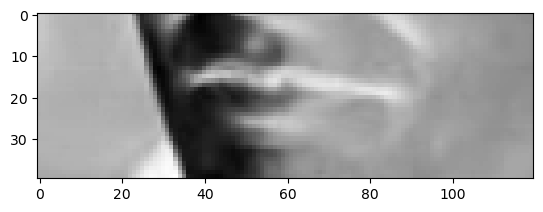

In [16]:
val = data.as_numpy_iterator().next()
plt.imshow(val[0][0][2], cmap='gray_r')
print(len(val[0][0]))

In [17]:
tf.strings.reduce_join([numToChar(word) for word in val[1][0]])
print("num of chars:", len(([numToChar(word) for word in val[1][0]])))

num of chars: 145


## designing the model

In [18]:
# imports for the model architecture 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPooling3D, TimeDistributed, Flatten, GRU
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
inputShape = data.as_numpy_iterator().next()[0][0].shape
print(inputShape)
print(charToNum.get_vocabulary())
print(len(charToNum.get_vocabulary()))

(290, 40, 120, 1)
['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']
28


In [22]:
# model to be actually trained
def createModel(x): 
    model = Sequential([
    Conv3D(32, 3, input_shape=inputShape, padding='same', activation='relu', name="conv1"),
    MaxPooling3D((1,2,2), name="maxPool1"),
    
    Conv3D(64, 3, padding='same', activation='relu', name="conv2"),
    MaxPooling3D((1,2,2), name="maxPool2"),
        
    Conv3D(96, 3,  padding='same', activation='relu', name="conv3"),
    MaxPooling3D((1,2,2), name="maxPool3"),
    
    TimeDistributed(Flatten()),
    
    # Bidirectional(LSTM(256, kernel_initializer='orthogonal', return_sequences=True)),
    Bidirectional(GRU(x, kernel_initializer='orthogonal', return_sequences=True)),
    Dropout(.5),
        
    # Bidirectional(LSTM(256, kernel_initializer='orthogonal' , return_sequences=True)),
    Bidirectional(GRU(x, kernel_initializer='orthogonal' , return_sequences=True)),
    Dropout(.5),
    
    Dense(charToNum.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
    ])
    return model
# model to be actually trained
def createModel2(x): 
    model = Sequential([
    Conv3D(180, kernel_size=(1,3,3), strides=(1,2,2), input_shape=inputShape, padding='same', activation='relu', name="conv1"),
    MaxPooling3D((1,2,2), name="maxPool1"),
    
    Conv3D(256, kernel_size=(1,2,2), strides=(1,2,2), padding='same', activation='relu', name="conv2"),
    MaxPooling3D((1,2,2), name="maxPool2"),
    Conv3D(256, kernel_size=(2,2,2), strides=(1,2,2), padding='same', activation='relu', name="conv3"),
    
    TimeDistributed(Flatten()),
    
    # Bidirectional(LSTM(256, kernel_initializer='orthogonal', return_sequences=True)),
    Bidirectional(GRU(x, kernel_initializer='orthogonal', return_sequences=True)),
    Dropout(.5),
        
    # Bidirectional(LSTM(256, kernel_initializer='orthogonal' , return_sequences=True)),
    Bidirectional(GRU(x, kernel_initializer='orthogonal' , return_sequences=True)),
    Dropout(.5),
    
    Dense(charToNum.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
    ])
    return model


In [23]:
model2 = createModel(256)

print("final model input shape:",  inputShape)
model2.summary()

final model input shape: (290, 40, 120, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 290, 40, 120, 32)  896       
                                                                 
 maxPool1 (MaxPooling3D)     (None, 290, 20, 60, 32)   0         
                                                                 
 conv2 (Conv3D)              (None, 290, 20, 60, 64)   55360     
                                                                 
 maxPool2 (MaxPooling3D)     (None, 290, 10, 30, 64)   0         
                                                                 
 conv3 (Conv3D)              (None, 290, 10, 30, 96)   165984    
                                                                 
 maxPool3 (MaxPooling3D)     (None, 290, 5, 15, 96)    0         
                                                                 
 time_distr

In [24]:
# custom functions 
def scheduler(epoch, lr):
    if epoch < 40:
        return lr        
    else:
        return lr * tf.math.exp(-0.1)

# custom loss function 
def CTCLoss(yTrue, yPred):
    # y true is the text alignment (None, 99) 
    # y pred is the end result of the model (154, 41) 
    batchLen = tf.cast(tf.shape(yTrue)[0], dtype="int64")

    inputLen = tf.cast(tf.shape(yPred)[1], dtype="int64")
    labelLen = tf.cast(tf.shape(yTrue)[1], dtype="int64")
    inputLen = inputLen * tf.ones(shape=(batchLen, 1), dtype="int64")
    labelLen = labelLen * tf.ones(shape=(batchLen, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(yTrue, yPred, inputLen, labelLen)   
    return loss 

class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        try: 
            data = self.dataset.next()
            yhat = self.model.predict(data[0])
       
            decoded = tf.keras.backend.ctc_decode(yhat, [maxFrameCt, maxFrameCt, maxFrameCt, maxFrameCt], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):           
                print('Original:', tf.strings.reduce_join(numToChar(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8'))
                print("Word Error Rate: ", str(wer(tf.strings.reduce_join(numToChar(data[1][x])).numpy().decode('utf-8'), tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8') ) * 100) + "%")
                print('~'*100)
        except: 
            pass     
      

In [25]:
def makePrediction(model, valuePassed=None): 
    if valuePassed is None: 
        value = val
    else: 
        value = valuePassed
    yhat = model.predict(value[0])
    
    decoded = tf.keras.backend.ctc_decode(yhat, [maxFrameCt, maxFrameCt, maxFrameCt, maxFrameCt], greedy=False)[0][0].numpy()
    originalArr = []
    predArr = []
    for x in range(len(yhat)):          
        original = tf.strings.reduce_join(numToChar(val[1][x])).numpy().decode('utf-8')
        prediction = tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8')
        originalArr.append(original)
        predArr.append(prediction )
        
        print('Original:', original)
        print('Prediction:', prediction)
        print("Word Error Rate on Prediction:", str(wer(original,prediction) * 100) + "%")
        print('~' * 40)
    print("Original:", originalArr, "\nPredictions:", predArr)
    print("Avg Word Error Rate:", str(wer(originalArr, predArr) * 100) + "%")

In [26]:
makePrediction(model2)

1/1 [==============================] - 5s 5s/step
Original: THEY MEET EACH OTHER OUTSIDE THE CHURCH
Prediction: GZGZGZGZGZGZGZYZGZGYLYE EJQJI EGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGEGHYN
Word Error Rate on Prediction: 100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: THEY WERE NEVER QUITE THE SAME WITHOUT HIM BECAUSE THE LEARINESS OF THE CARRY ON FILMS
Prediction: GRMRMGGMMMMFGRMMGMMRMRFMFRMRMRMRMMMLMYMYMYMQMOJAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAHZ
Word Error Rate on Prediction: 100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: IVE BEEN VERY BUSY BABY SITTING MY NEW THREE WEEK OLD GRANDDAUGHTER
Prediction: GRMRFRFMVMVMRMMRMRMRMVMVMVMVMVRMRMVXVXMRMRMKMYMYMYMYMYMYKMUFEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEWEV
Word Error Rate on Prediction: 100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: THESE GUYS HAVE MEMORIES OF THE DAY THEY BUILT AN EXTENSION SOMEWHERE IN GLOUCESTER
Prediction: AKYKRKRKYKRKYKYKYKYGYKGKGKGKRGRKRYRKRKRKRKRK

## compilign the model??

In [27]:
print(errorPaths)
print(errorNums)
print(errorInfo)
print(lastKnownCrop)

[]
0
[]
(36, 5, 101, 101)


In [28]:
print(errorPaths)
print(errorInfo)
print(lastKnownCrop)

[]
[]
(36, 5, 101, 101)


In [29]:
errorNums

0

In [30]:
model2.compile(optimizer=Adam(learning_rate=0.0002), loss=CTCLoss)
# create all the callbacks 
checkpointCallback2 = ModelCheckpoint('newLipModelv11_m2.weights.h5', monitor='loss',save_weights_only=False, save_freq='epoch') # save checkpoints after each epoch
scheduleCallback2 = LearningRateScheduler(scheduler)
exampleCallback2 = ProduceExample(test)

In [32]:
model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)

Epoch 1/300
1/1 [==============================] - 2s 2s/step
Original: AND THE LOWER HALF OF ALEXANDERS BODY WAS SHATTERED
Prediction: I E E E E E E E E E E E E 
Word Error Rate:  144.44444444444443%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: JOE PASSED AWAY AND WITH ADAM AND HIS FAMILYS PERMISSION
Prediction: I E E E E E E E E E E E E E E 
Word Error Rate:  150.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: SO A FARM LIKE THIS
Prediction: I E E E E 
Word Error Rate:  100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: ONE OF US DECIDES THAT WERE GOING TO DO SOMETHING TOGETHER OF THEIR CHOICE
Prediction: I E E E E E E E E E E E E E E E E E E 
Word Error Rate:  135.71428571428572%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
171/171 

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Pack_N_67_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [40,120,1] != values[19].shape = [40,1,120] [Op:Pack] name: packed
Traceback (most recent call last):

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\monis\AppData\Local\Temp\ipykernel_9104\3629012439.py", line 13, in loadData
    frames = loadVideo(videoPath)

  File "C:\Users\monis\AppData\Local\Temp\ipykernel_9104\3629012439.py", line 52, in loadVideo
    mean = tf.math.reduce_mean(processedFrames, keepdims=True)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 7209, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Pack_N_67_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [40,120,1] != values[19].shape = [40,1,120] [Op:Pack] name: packed


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  InvalidArgumentError: {{function_node __wrapped__Pack_N_67_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [40,120,1] != values[19].shape = [40,1,120] [Op:Pack] name: packed
Traceback (most recent call last):

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\monis\AppData\Local\Temp\ipykernel_9104\3629012439.py", line 13, in loadData
    frames = loadVideo(videoPath)

  File "C:\Users\monis\AppData\Local\Temp\ipykernel_9104\3629012439.py", line 52, in loadVideo
    mean = tf.math.reduce_mean(processedFrames, keepdims=True)

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "C:\Users\monis\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 7209, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Pack_N_67_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [40,120,1] != values[19].shape = [40,1,120] [Op:Pack] name: packed


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_698881]

In [ ]:
model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)

Epoch 1/300
121/171 [====================>.........] - ETA: 52s - loss: 74.4674

In [ ]:
try: 
    model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)
except: 
    try: 
        model2.load_weights('newLipModelv11_m2.weights.h5')
        model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)
    except: 
        try: 
            model2.load_weights('newLipModelv11_m2.weights.h5')
            model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)
        except: 
            try: 
                model2.load_weights('newLipModelv11_m2.weights.h5')
                model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)
            except: 
                try: 
                    model2.load_weights('newLipModelv11_m2.weights.h5')
                    model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)
                except: 
                    print("fml")

In [229]:
model2.save_weights('')

ValueError: Invalid bias shape: (1024,)

In [ ]:
model.fit(train, validation_data=test, epochs=200, callbacks=[scheduleCallback, checkpointCallback, exampleCallback])

In [ ]:
yHat = model.predict(val[0])
print(tf.strings.reduce_join([numToChar(tf.argmax(x)) for x in yHat[0]]))

In [ ]:
# Get training and test loss histories
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();